In [ ]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

from utils import show_images, blackAndWhite

import torch
import torch.nn as nn
import torch.optim as optim

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
import pandas as pd
import os
import shutil

df = pd.read_csv('inverted/invertedLabels.csv')
root = 'inverted'

imagesRoot = os.path.join('images', 'train')
unusable = 'unusable'

for index, row in df.iterrows():
    imageName = f'{row["image"]}.jpeg'
    source = os.path.join(imagesRoot, imageName)
    
    if os.path.exists(source):
        dest = os.path.join(f'{unusable if row["inverted"] == -1 else root}',f'{row["inverted"]}')
        dest = os.path.join(dest, imageName)
        shutil.copy(source, dest)
    

In [4]:
batch_size = 64
scale_size = (256, 256)

root = 'inverted'

In [5]:
def crop(img):
    width, height = img.size
    return torchvision.transforms.functional.crop(img, 0, width/2, width, height)

images = ImageFolder(
    root=root,
    transform=transforms.Compose([
        transforms.Resize(scale_size),
        # transforms.Lambda(crop),
        transforms.ToTensor(), 
        # transforms.Normalize([0.41661593, 0.29097975, 0.20843531], [0.26398131, 0.19219237, 0.15810781]),
        # transforms.Lambda(blackAndWhite),
    ]),
)

# idx = [i for i in range(len(images)) if images.imgs[i][1] != images.class_to_idx.get('-1')]
# images = Subset(images, idx)

train_size = int(0.8 * len(images))
test_size = len(images) - train_size

train_dataset, test_dataset = random_split(images, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

images.classes


['0', '1']

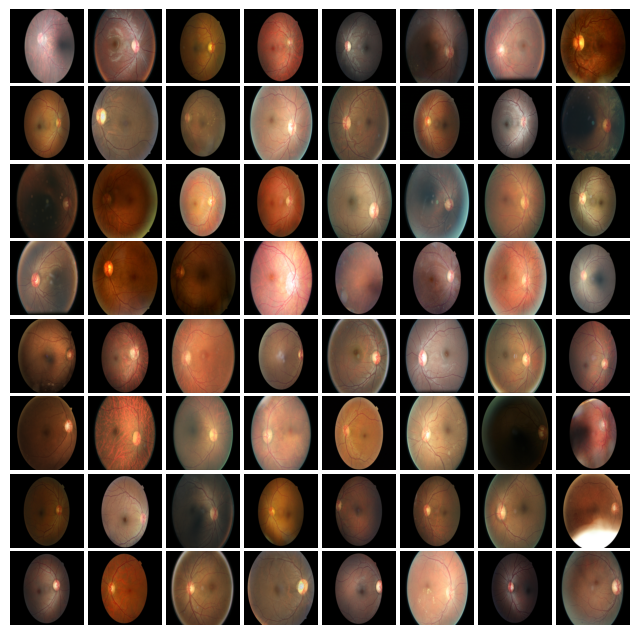

In [6]:
imgs, _ = next(iter(train_loader))
show_images(imgs.numpy().squeeze(), color=True)

In [ ]:

from InversionClassifier import InversionClassifier

model = InversionClassifier().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, fused=True, nesterov=True, momentum=0.9, weight_decay=1e-4)

num_epochs = 20
for epoch in range(num_epochs):
    print(f'Epoch: {epoch}')
    model.train()
    totLoss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        
        loss.backward()
        optimizer.step()
        
        totLoss += loss.item()
    
    print(f'Avg Loss: {totLoss / len(train_loader)}')
    
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:   
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, pred = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()
            
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy}%')


Epoch: 0
Avg Loss: 0.45597497480256216
Accuracy: 85.42199488491049%
Epoch: 1
Avg Loss: 0.3352942627911665
Accuracy: 89.38618925831202%
Epoch: 2
Avg Loss: 0.29107537379070203
Accuracy: 90.28132992327366%
Epoch: 3
Avg Loss: 0.267527917514042
Accuracy: 91.68797953964194%
Epoch: 4
Avg Loss: 0.2510570509701359
Accuracy: 92.1994884910486%
Epoch: 5
Avg Loss: 0.23442160201315976
Accuracy: 92.71099744245524%
Epoch: 6
Avg Loss: 0.2266050604533176
Accuracy: 92.8388746803069%
Epoch: 7
Avg Loss: 0.21926930790044824
Accuracy: 91.81585677749361%
Epoch: 8
Avg Loss: 0.2137091883591243
Accuracy: 93.09462915601023%
Epoch: 9
Avg Loss: 0.204962178912698
Accuracy: 92.96675191815856%
Epoch: 10
Avg Loss: 0.19845120669627675
Accuracy: 92.71099744245524%
Epoch: 11
Avg Loss: 0.1906193183088789
Accuracy: 92.71099744245524%
Epoch: 12
Avg Loss: 0.1915341396721042
Accuracy: 90.66496163682865%
Epoch: 13
